# Supernovae as Standard Candles
## 3. Statistical Inference


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sympy import symbols, Eq, init_printing
import numpy as np
from scipy.interpolate import CubicSpline

# List to store tuples of plottable info
Mags_Delm15 = []

# File containing the supernova data
file_path = "Supernova_Ia/table4.dat"

def phillips_relation(delta_m_15):
    '''
    Calculates the absolute magnitude of the SN's peak brightness in the Blue filter
    '''
    M_max_B = -21.726 + 2.698*delta_m_15
    return M_max_B

init_printing()
M, delta_m_15 = symbols('M_{max}(B) Δm_{15}(B)')
phillips_eq = Eq(M, - 21.726 + ( 2.698 * delta_m_15 ))


# Read the file into a pandas DataFrame
columns = ["prefix", "SN", "JD", "U_mag", "U_err", "B_mag", "B_err", "V_mag", "V_err", "R_mag", "R_err", "I_mag", "I_err", "Source"]
df = pd.read_csv(file_path, comment="#", sep="[ \t]+", engine="python", header=0,
                 names=columns)

# filter out unneeded magnitudes as the phillips relation is in B mag (U_mag because if NaN values occur everything gets shifted to the left)
UB_filter = df[["SN", "JD", "U_mag", "U_err", "B_mag", "B_err"]].dropna()

# get rid of the U mag too
B_filter = UB_filter[["SN", "JD", "B_mag", "B_err"]]

unique_sne = B_filter["SN"].unique()

# group the different SNe
sn_group = B_filter.groupby("SN")


for sn in unique_sne:
    try:
        sn_data = B_filter[B_filter["SN"] == sn] # creates mini df for each SN

        # Find time of maximum brightness and corresponding magnitude
        start_idx = sn_data["JD"].idxmin() # Index of first item of specific SN 
        max_idx = sn_data["B_mag"].idxmin() # Index of maximum brightness
        max_idx = max_idx - start_idx #index correction, df -> sn df index
        max_day = float(sn_data["JD"].iat[max_idx]) # Date of maximum brightness 
        m_b_max = float(sn_data["B_mag"].iat[max_idx]) # Max brightness
        max_day15 = max_day + 15 # Date 15 days after maximum
        closest_index = (sn_data["JD"] - max_day15).abs().idxmin() # Index of closest day with a measurement around the 15th day
        closest_index = closest_index - start_idx
        closest_day = sn_data["JD"].iat[closest_index] # Date of 15th/closeest day
        

        if abs(closest_day - max_day15) < 3:
            m_b_15 = float(sn_data["B_mag"].iat[closest_index]) # Mag on 15th/closest day
        else:
            jd_known = sn_data["JD"].values
            mag_known = sn_data["B_mag"].values
            spl = CubicSpline(jd_known,mag_known)
            m_b_15 = spl(max_day15) # Interpolate an approximate value for mag on 15th day

        # Calculate ∆m15
        delta_m15 = m_b_15 - m_b_max
        print("SN", sn)
        print("max apparent B_mag:", m_b_max)
        M_B = phillips_relation(delta_m15) 
        print("Phillips:", M_B, "mag")

        # distance to the supernova
        mu = m_b_max - M_B
        distance_pc = 10 ** ((mu + 5) / 5)
        distance_mpc = distance_pc/(10**6)
        print("distance:", distance_mpc, "Mpc")

        if M_B > (-22):
            Mags_Delm15.append((M_B, m_b_max, delta_m15, distance_mpc)) #max abs, max obs, del m 15, dist [Mpc]
        else:
            print('Outlier skipped')

        print()

    except Exception as oops:
        print(f"{sn} ignored due to error: {oops}")



# Creates numpy array out of list for plotting/ data analysis
data_array = np.array(Mags_Delm15)

max_abs_mag = data_array[:,0]
max_obs_mag = data_array[:,1]
del_m = data_array[:,2]
dist = data_array[:,3]



SN 1997E
max apparent B_mag: 15.62
Phillips: -16.974821999999996 mag
distance: 33.03424610850272 Mpc

SN 1997Y
max apparent B_mag: 15.379
Phillips: -24.407578572416806 mag
distance: 906.3912711676822 Mpc
Outlier skipped

SN 1997bp
max apparent B_mag: 14.085
Phillips: -18.62903863736893 mag
distance: 34.898577694447276 Mpc

SN 1997bq
max apparent B_mag: 14.824
Phillips: -20.563162 mag
distance: 119.51774761403583 Mpc

SN 1997br
max apparent B_mag: 14.317
Phillips: -21.580308 mag
distance: 151.1686031279803 Mpc

SN 1997cn
max apparent B_mag: 18.062
Phillips: -28.960341546896714 mag
distance: 25378.637903961244 Mpc
Outlier skipped

SN 1997cw
max apparent B_mag: 16.892
Phillips: -17.289226887852088 mag
distance: 68.58756386101247 Mpc

SN 1997dg
max apparent B_mag: 17.178
Phillips: -19.38596548394279 mag
distance: 205.4911377793112 Mpc

SN 1997do
max apparent B_mag: 14.626
Phillips: -21.329393999999997 mag
distance: 155.26687063645178 Mpc

SN 1997dt
max apparent B_mag: 15.402
Phillips: -18.

## Combined quantity data plot

This is a scatterplot showing the relationship between the maximum observed magnitude of the Supernova and the difference in magnitude between the peak brightness and the brightness of the SN 15 days after the peak.

We can observe that most SNe get around 0.5 - 2 magnitude dimmer within 15 days

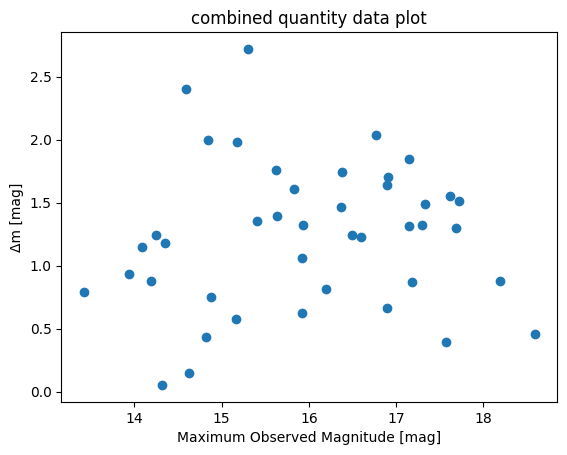

In [86]:
plt.scatter(max_obs_mag, del_m)
#plt.semilogy()
plt.xlabel('Maximum Observed Magnitude [mag]')
plt.ylabel('Δm [mag]')
plt.title('combined quantity data plot')

plt.show()

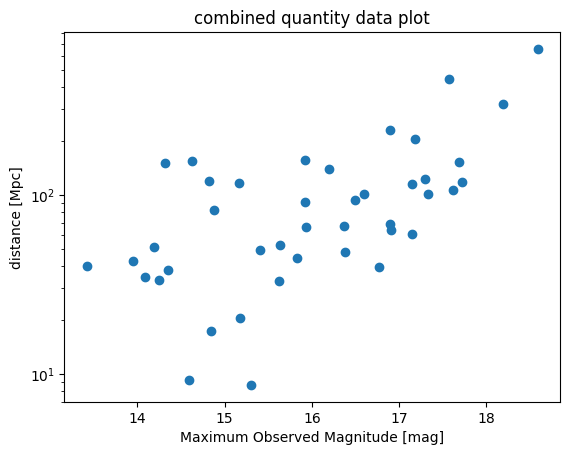

In [87]:
plt.scatter(max_obs_mag, dist)
plt.semilogy()
plt.xlabel('Maximum Observed Magnitude [mag]')
plt.ylabel('distance [Mpc]')
plt.title('combined quantity data plot')

plt.show()

## Maximum Absolute Magnitude vs Δm
## The Phillips Relation

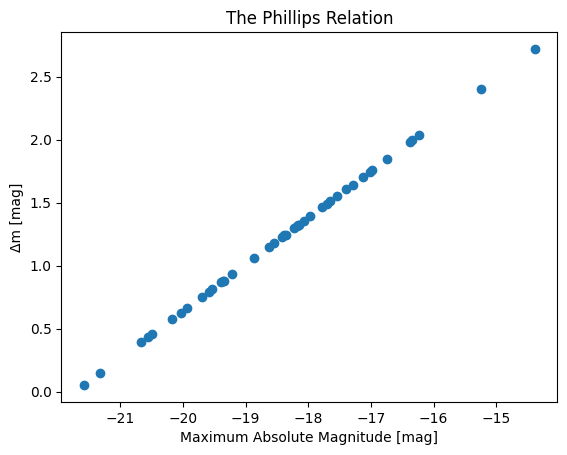

In [88]:
plt.scatter(max_abs_mag, del_m)
plt.xlabel('Maximum Absolute Magnitude [mag]')
plt.ylabel('Δm [mag]')
plt.title('The Phillips Relation')

plt.show()



## Maximum Absolute Magnitude of a type Ia Supernova

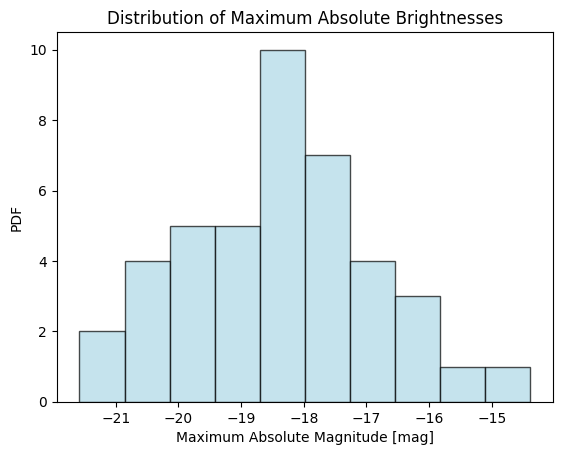

In [89]:
plt.hist(max_abs_mag, bins=10, edgecolor='black',color = 'lightblue', alpha=0.7)

plt.xlabel('Maximum Absolute Magnitude [mag]')
plt.ylabel('PDF')
plt.title('Distribution of Maximum Absolute Brightnesses')

plt.show()



## Analysing the distribution of Maximum Absolute Magnitudes 

Mean =  -18.40213819346488
Standard deviation =  1.5590034877473866


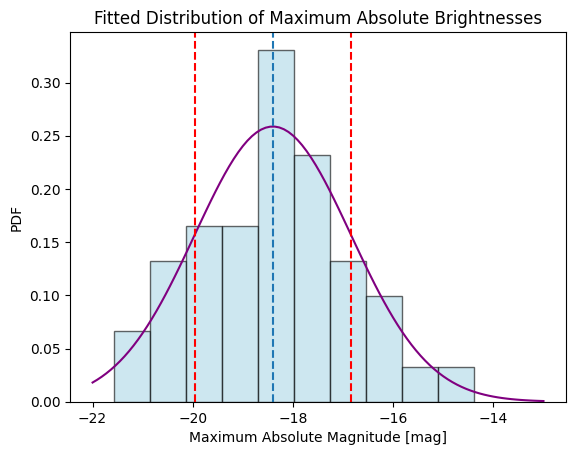

In [90]:
from scipy.optimize import curve_fit

counts, bins, patches = plt.hist(max_abs_mag, bins = 10, edgecolor='black', color = 'lightblue', density = True, alpha=0.6, label = 'SNe')

plt.xlabel('Maximum Absolute Magnitude [mag]')
plt.ylabel('PDF')
plt.title('Fitted Distribution of Maximum Absolute Brightnesses')


#define function to fit
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

#calculate bin center to use as y data to fit
bins = (bins[:-1] + np.diff(bins) / 2)

#create an arbitrary x axis to fit
x_values_to_fit = np.linspace(-22,-13,100)

# fit the data and plot the result
param, cov = curve_fit(gaussian, bins,counts, p0=[1, np.mean(max_abs_mag), np.std(max_abs_mag)])
plt.plot(x_values_to_fit, gaussian(x_values_to_fit, *param), '-', color = 'purple', lw=1.5)

# access fit parameters
mean_gaus = param[1] #mean of gaussian dist
std_gaus   = param[2] #stdev of the dist

print('Mean = ', mean_gaus)
print('Standard deviation = ', std_gaus)

plt.axvline(mean_gaus, linestyle = 'dashed')
plt.axvline(mean_gaus - std_gaus, color = 'red', linestyle = 'dashed')
plt.axvline(mean_gaus + std_gaus, color = 'red', linestyle = 'dashed')

plt.show()

## n - sigma confidence intervals

2.5-sigma Confidence Interval: (-22.30, -14.50)


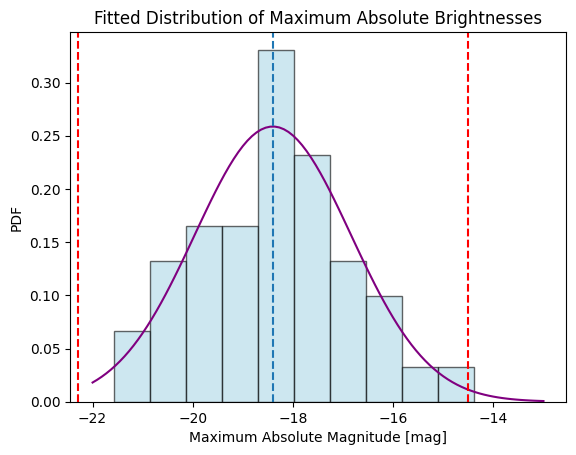

In [91]:

from scipy.optimize import curve_fit

def n_sigma_confidence_interval(sigma, mu, n):
    # Calculate the confidence interval
    lower_bound = mu - n * sigma
    upper_bound = mu + n * sigma
    
    return lower_bound, upper_bound


n = 2.5

lower, upper = n_sigma_confidence_interval(std_gaus, mean_gaus, n)

print(f"{n}-sigma Confidence Interval: ({lower:.2f}, {upper:.2f})")


# Fitted histogram plotting

counts, bins, patches = plt.hist(max_abs_mag, bins = 10, edgecolor='black', color = 'lightblue', density = True, alpha=0.6, label = 'SNe')

plt.xlabel('Maximum Absolute Magnitude [mag]')
plt.ylabel('PDF')
plt.title('Fitted Distribution of Maximum Absolute Brightnesses')


#define function to fit
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

#calculate bin center to use as y data to fit
bins = (bins[:-1] + np.diff(bins) / 2)

#create an arbitrary x axis to fit
x_values_to_fit = np.linspace(-22,-13,100)

# fit the data and plot the result
param, cov = curve_fit(gaussian, bins,counts, p0=[1, np.mean(max_abs_mag), np.std(max_abs_mag)])
plt.plot(x_values_to_fit, gaussian(x_values_to_fit, *param), '-', color = 'purple', lw=1.5)

# access fit parameters
mean_gaus = param[1] #mean of gaussian dist
std_gaus   = param[2] #stdev of the dist

#print('Mean = ', mean_gaus)
#print('Standard deviation = ', std_gaus)

plt.axvline(mean_gaus, linestyle = 'dashed')
plt.axvline(lower, color = 'red', linestyle = 'dashed')
plt.axvline(upper, color = 'red', linestyle = 'dashed')

plt.show()

## 4. Hypothesis Testing

In this subsection we will discuss the combined quantity data plot "Distance in Mpc vs the Maximum Observed Brightness". Let's define our combined quantity as X:=(10^m)/d
As a refresher, here is the plot:

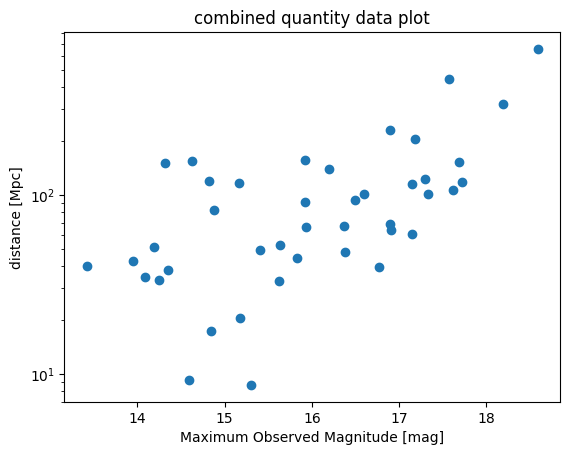

In [92]:
plt.scatter(max_obs_mag, dist)
plt.semilogy()
plt.xlabel('Maximum Observed Magnitude [mag]')
plt.ylabel('distance [Mpc]')
plt.title('combined quantity data plot')

plt.show()

We expected a stronger correlation between these two measurements, since we want to use Type Ia supernovae to determine the distance to far away galaxies. We would like to find out if the spread of the data is statistically significant.

H_0: The value of X can be considered constant for all SNe Ia

H_a: The value of X can NOT be considered constant for all SNe Ia

Let's choose a subset and test this hypothesis. 
Let the subset be SNe within 100 MPc of the sun.

In [93]:
sub_data = data_array[data_array[:, 3] <= 100]
print(sub_data)

#max abs mag   max obs mag    del m     distance

[[-16.974822    15.62         1.761       33.03424611]
 [-18.62903864  14.085        1.147873    34.89857769]
 [-17.28922689  16.892        1.64446742  68.58756386]
 [-18.06689716  15.402        1.35622789  49.40597011]
 [-18.871516    15.917        1.058       90.7200331 ]
 [-17.009896    16.384        1.748       47.72865543]
 [-14.384742    15.307        2.721        8.6765765 ]
 [-18.16394326  15.93         1.32025824  65.88531889]
 [-19.35505096  14.193        0.87878022  51.24012624]
 [-18.3618666   16.494        1.24689896  93.57790531]
 [-16.34348088  14.843        1.99500338  17.27015266]
 [-19.211464    13.945        0.932       42.78512449]
 [-16.227476    16.765        2.038       39.67301441]
 [-19.694406    14.876        0.753       82.05049397]
 [-18.37851141  14.253        1.24072965  33.59713792]
 [-17.11846382  16.907        1.70775989  63.83998315]
 [-18.54789516  14.354        1.17794842  38.05213524]
 [-15.23642389  14.594        2.40532843   9.24878699]
 [-17.3934

In [94]:
#calculate X

X_sub = np.divide(np.power(10,sub_data[:,1]),sub_data[:,3])
X_data = np.divide(np.power(10,data_array[:,1]),data_array[:,3])
#print(X_sub)
#print(X_data)

Now that we calculated X=m/d for both the subset and the entire dataset, let's plot a histogram.

Entire data set stats:
 Mean:  906176715507192.4 
 Standard deviation 1458590402960090.2
Subset data stats:
 Mean:  352306690962450.0 
 Standard deviation 585037638848078.9


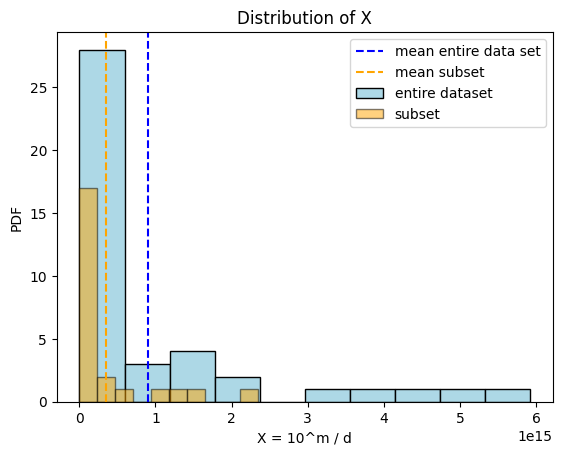

In [95]:
plt.hist(X_data, bins=10, edgecolor = 'black', color = 'lightblue', alpha=1)
plt.hist(X_sub, bins=10, edgecolor = 'black', color = 'orange', alpha=0.5)

mean_X_data = np.mean(X_data)
mean_X_sub = np.mean(X_sub)
std_X_data = np.std(X_data)
std_X_sub = np.std(X_sub)
print('Entire data set stats:\n Mean: ', mean_X_data, '\n Standard deviation', std_X_data)
print('Subset data stats:\n Mean: ', mean_X_sub, '\n Standard deviation', std_X_sub)

plt.axvline(mean_X_data, color = 'blue', linestyle = 'dashed')
plt.axvline(mean_X_sub, color = 'orange', linestyle = 'dashed')
plt.xlabel('X = 10^m / d')
plt.ylabel('PDF')
plt.title('Distribution of X')
plt.legend(['mean entire data set', 'mean subset', 'entire dataset', 'subset'], loc = "upper right")

plt.show()

In [96]:
from scipy.stats import ttest_ind

n = len(X_sub)
t = abs(mean_X_sub - mean_X_data) / (std_X_sub / np.sqrt(n))
print('t = ', t)
t_stat, p_val = ttest_ind(X_data, X_sub)
print('t statistic = ', t_stat)
print('p value = ', p_val)

t =  4.637988580114988
t statistic =  1.7530750756502262
p value =  0.0843776396134172


Let's test out hypothesis with 5% significance level.

In [97]:
if (p_val < 0.05):
    print('We can reject H_0')
else:
    print('We can not reject H_0')


We can not reject H_0


H_0: The value of X can be considered constant for all SNe Ia

H_a: The value of X can NOT be considered constant for all SNe Ia

Since we can not reject H_0 this means that the ratio between the observed magnitude and the distance to a supernova is a constant and does not vary significantly. This is a good result for us, because this means that Type Ia SNe have indeed a constant peak brightness. Therefore we can use these cosmic events to determine distances.